In [1]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
from torch import nn

In [45]:
RANDOM_SEED = 11

https://www.timeseriesclassification.com/description.php?Dataset=ECG5000

In [2]:
data_train = arff.loadarff('./ECG5000/ECG5000_TRAIN.arff')
data_test = arff.loadarff('./ECG5000/ECG5000_TEST.arff')
df = pd.concat([pd.DataFrame(data_train[0]), pd.DataFrame(data_test[0])], axis = 'index')

In [3]:
df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,b'4'
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,b'2'
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,b'2'
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,b'2'


In [4]:
val_target = df.target.unique()

In [5]:
val_target

array([b'1', b'2', b'3', b'4', b'5'], dtype=object)

In [6]:
int(val_target[0].decode("utf-8"))

1

In [7]:
classes = ['N', 'RoT PVC', 'PVC', 'SP EB', 'UB']
def format_target_column(target, classes):
    int_target = int(target.decode("utf-8"))
    return classes[int_target-1]

In [8]:
df['target_formated'] = df['target'].apply(lambda x : format_target_column(x, classes))

In [9]:
df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att133,att134,att135,att136,att137,att138,att139,att140,target,target_formated
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1',N
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1',N
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1',N
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1',N
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1',N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,b'4',SP EB
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,b'2',RoT PVC
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,b'2',RoT PVC
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,b'2',RoT PVC


In [10]:
#df = df.sample(frac = 1)

In [11]:
df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att133,att134,att135,att136,att137,att138,att139,att140,target,target_formated
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1',N
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1',N
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1',N
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1',N
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1',N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,b'4',SP EB
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,b'2',RoT PVC
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,b'2',RoT PVC
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,b'2',RoT PVC


In [12]:
list = df['target_formated'].value_counts()

Text(0, 0.5, 'Counter')

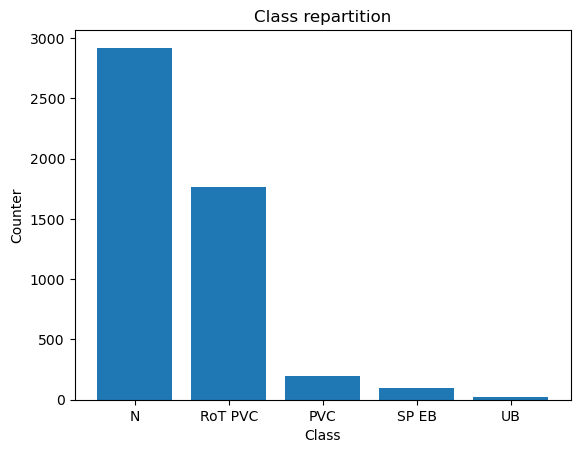

In [13]:
plt.bar(classes, list.values)
plt.title('Class repartition')
plt.xlabel('Class')
plt.ylabel('Counter')

In [14]:
df['Normal'] = df.target_formated.apply(lambda x: 1 if x=='N' else 0)

In [15]:
dff = df.drop(['target', 'target_formated', 'Normal'], axis='columns')

In [16]:
dff.mean(axis = 'index')

att1     -0.262476
att2     -1.649511
att3     -2.492211
att4     -3.119443
att5     -3.167438
            ...   
att136   -0.761043
att137   -0.834741
att138   -0.642263
att139   -0.487242
att140   -0.706008
Length: 140, dtype: float64

In [29]:
def plot_serie(data, class_name, window=10):
    mean = data.mean(axis='index')
    std = data.std(axis='index')
    mean_smooth = mean.rolling(window=window, center=True).mean()
    std_smooth = std.rolling(window=window, center=True).mean()
    plt.figure(figsize=(6, 3))
    plt.plot(mean_smooth, label='Mean (smoothed)', color='blue')
    plt.fill_between(range(data.shape[1]), 
                     mean_smooth - std, 
                     mean_smooth + std, 
                     color='blue', alpha=0.2, label='Std (smoothed)')

    plt.title('Mean representation of ' + class_name)
    plt.legend()
    plt.xticks(np.linspace(0, len(mean), 5))
    plt.show()

In [30]:
data = dff.copy()

In [31]:
mean_smooth = data.rolling(window=10).mean()
mean_smooth.dropna(inplace=True)

In [32]:
std_smooth = data.rolling(window=10, center=True).std()
std_smooth.dropna(inplace=True)

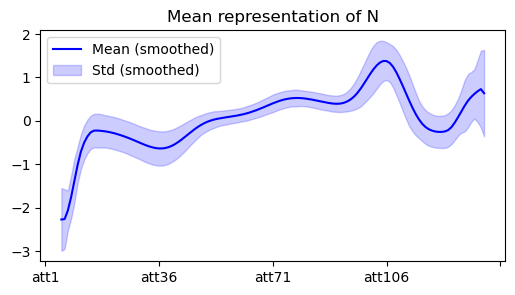

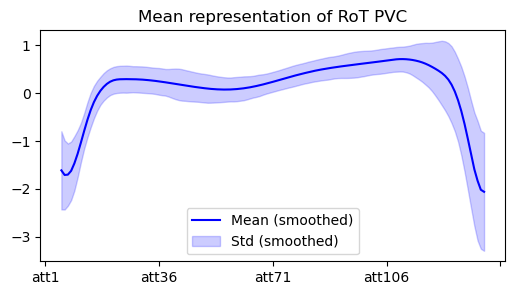

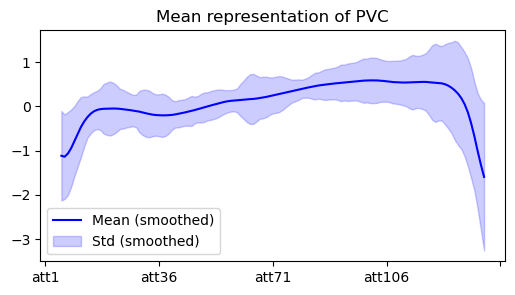

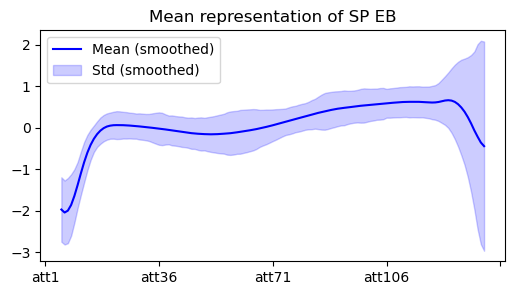

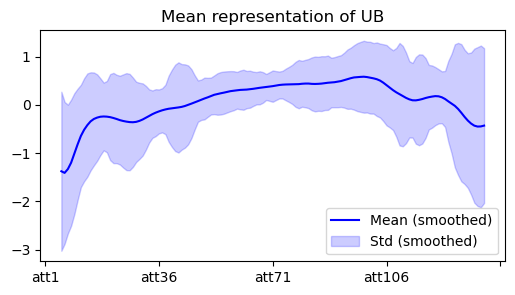

In [34]:
for class_name in classes:
    df_tmp = df[df.target_formated==class_name].drop(['target', 'target_formated', 'Normal'], axis='columns')
    plot_serie(df_tmp, class_name)

We observe that only the normal beats have a final pattern going up. We will try to build a model that can take that into account.

In [64]:
df_normal = df[df.Normal==1].drop(['target', 'target_formated'], axis='columns')
df_abnormal = df[df.Normal==0].drop(['target', 'target_formated'], axis='columns')

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
train_df_tmp, test_df = train_test_split(df_normal, test_size=0.1, random_state=RANDOM_SEED)
train_df, val_df = train_test_split(train_df_tmp, test_size=0.1, random_state=RANDOM_SEED)

In [67]:
print(f'The train dataset contains {train_df.shape[0]} samples')
print(f'The test dataset contains {test_df.shape[0]} samples')
print(f'The validation dataset contains {val_df.shape[0]} samples')

The train dataset contains 2364 samples
The test dataset contains 292 samples
The validation dataset contains 263 samples


In [118]:
def create_dataset_from_df(df):
    sequences = df.values.tolist()
    dataset = [torch.tensor(seq).view(-1, 1) for seq in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [120]:
train_dataset, seq_len, n_features = create_dataset_from_df(train_df)
test_dataset, seq_len, n_features = create_dataset_from_df(test_df)
val_dataset, seq_len, n_features = create_dataset_from_df(val_df)
abnormal_dataset, seq_len, n_features = create_dataset_from_df(df_abnormal)

In [126]:
print(type(train_dataset))
print(type(train_dataset[0]))
print(type(train_dataset[0][0]))
print(train_dataset[0][0])

<class 'list'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([-2.0365])


In [143]:
class LSTMencoder(nn.Module):
    def __init__(self, seq_len, n_features, neurons_latent_layer=64, batch_size=1):
        super().__init__()
        self.hidden_layer_size = 2*neurons_latent_layer
        self.num_layers = 1
        self.seq_len = seq_len
        self.n_features = n_features
        self.neurons_latent_layer = neurons_latent_layer
        self.batch_size = batch_size
        
        self.lstm1 = nn.LSTM(
            input_size= self.n_features,     
            hidden_size= self.hidden_layer_size, 
            num_layers= self.num_layers, 
            batch_first=True   
        )
        self.lstm2 = nn.LSTM(
            input_size= self.hidden_layer_size,     
            hidden_size= self.neurons_latent_layer, 
            num_layers= self.num_layers, 
            batch_first=True   
        )

    def forward(self, x):
        x = x.reshape((self.batch_size, self.seq_len, self.n_features))
        x, (h_n, c_n) = self.lstm1(x)
        x, (h_n, c_n) = self.lstm2(x)
        return h_n.reshape((self.batch_size, self.neurons_latent_layer))

class LSTMdecoder(nn.Module):
    def __init__(self, output_size, seq_len, n_features, neurons_latent_layer=64, batch_size=1):
        super().__init__()
        self.neurons_latent_layer = neurons_latent_layer
        self.hidden_layer_size = 2* neurons_latent_layer
        self.num_layers = 1
        self.output_size = output_size
        self.seq_len = seq_len
        self.n_features = n_features
        self.batch_size = batch_size

        self.latent = nn.LSTM(
            input_size = self.neurons_latent_layer,
            hidden_size = self.neurons_latent_layer,
            num_layers = self.num_layers,
            batch_first = True
        )
        self.lstm = nn.LSTM(
            input_size = self.neurons_latent_layer,
            hidden_size = self.hidden_layer_size,
            num_layers = self.num_layers,
            batch_first = True
        )
        self.dense = nn.Linear(self.hidden_layer_size, self.output_size)
            
    def forward(self, x):
        x = x.repeat(self.seq_len, 1)
        x = x.reshape((self.batch_size, self.seq_len, self.neurons_latente_layer))
        x, (h_n, c_n) = self.lstm1(x)
        x, (h_n, c_n) = self.lstm2(x)
        return h_n.reshape((batch_size, embedding_dim))
        

In [144]:
model = LSTMencoder(input_size=n_features, hidden_layer_size=72, num_layers=2)